In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
%cd /content/drive/MyDrive/Yeast

/content/drive/MyDrive/Yeast


In [16]:
import os
import cv2
import tensorflow as tf
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense , Dropout
from keras.models import Sequential
from keras.metrics import F1Score, Accuracy
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split, KFold
from keras.utils import to_categorical
from numpy import mean,std
from matplotlib import pyplot as plt
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import shuffle
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow

### *Xây dựng mô hình CNN*

In [ ]:
train_file = os.listdir("dataset/non-aug/train/abnormal")[:600] + os.listdir("dataset/non-aug/train/normal")[:600]

In [ ]:
valid_file = os.listdir("dataset/non-aug/train/abnormal")[600:] + os.listdir("dataset/non-aug/train/normal")[600:]

In [ ]:
print(len(train_file))
print(len(valid_file))

1200
202


In [ ]:
def pad_image(image_path, target_size):
    # Đọc ảnh từ đường dẫn
    img = cv2.imread(image_path)

    # Kiểm tra nếu ảnh được đọc thành công
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")

    # Lấy kích thước hiện tại của ảnh
    h, w = img.shape[:2]

    # Tính toán số lượng padding cần thiết
    pad_h = max(0, (target_size[0] - h) // 2)
    pad_w = max(0, (target_size[1] - w) // 2)

    ex1 = (target_size[0] - h) % 2
    ex2 = (target_size[1] - w) % 2
    # Pad ảnh sao cho kích thước đạt target_size
    padded_img = cv2.copyMakeBorder(
        img,
        pad_h, pad_h + ex1, pad_w, pad_w +ex2,
        borderType=cv2.BORDER_CONSTANT,
        value=0  # Padding với màu đen (giá trị 0)
    )

    # Cắt ảnh nếu kích thước vượt quá target_size sau padding
    padded_img = padded_img[:target_size[0], :target_size[1]]

    return padded_img

In [ ]:
x_train = []
y_train = []
for i in range(len(train_file)):
  if(i < len(train_file)//2):
    img = cv2.imread("dataset/non-aug/train/abnormal/"+train_file[i])
    img = pad_image("dataset/non-aug/train/abnormal/"+train_file[i], (32,32))
    x_train.append(img)
    y_train.append(1)
  else:
    img = cv2.imread("dataset/non-aug/train/normal/"+train_file[i])
    img = pad_image("dataset/non-aug/train/normal/"+train_file[i], (32,32))
    x_train.append(img)
    y_train.append(0)

In [ ]:
x_valid = []
y_valid = []
for i in range(len(valid_file)):
  if(i < len(os.listdir("dataset/non-aug/train/abnormal")) - len(train_file)//2):
    img = cv2.imread("dataset/non-aug/train/abnormal/"+valid_file[i])
    img = pad_image("dataset/non-aug/train/abnormal/"+valid_file[i], (32,32))
    x_valid.append(img)
    y_valid.append(1)
  else:
    img = cv2.imread("dataset/non-aug/train/normal/"+valid_file[i])
    img = pad_image("dataset/non-aug/train/normal/"+valid_file[i], (32,32))
    x_valid.append(img)
    y_valid.append(0)

In [ ]:
x_train,y_train = shuffle(x_train,y_train, random_state = 19)
x_valid,y_valid = shuffle(x_valid,y_valid,  random_state = 4)

In [ ]:
def prep_pixels(train, test):
 # convert from integers to floats
 train_norm = train.astype('float32')
 test_norm = test.astype('float32')
 # normalize to range 0-1
 train_norm = train_norm / 255.0
 test_norm = test_norm / 255.0
 # return normalized images
 return train_norm, test_norm

In [ ]:
x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_train, x_valid = prep_pixels(x_train, x_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

In [ ]:
save_dir = 'files/non-aug'
filepath = os.path.join(save_dir, 'best_yeast_classification_model.hdf5')

In [ ]:

callback_1 = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='max',
    verbose=1 # Hiển thị thông tin model lúc checkpoint
)
def define_model():
    model = Sequential()

    # Layer Conv2D đầu tiên
    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer Conv2D thứ hai
    model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer Conv2D thứ ba
    model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    # Flatten và Dense
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dense(2, activation="softmax"))


    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

# Định nghĩa mô hình
model = define_model()

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_36 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_37 (Ba  (None, 16, 16, 64)        256       
 tchNormalization)                                               
                                                     

In [ ]:
model.fit(x_train,y_train, epochs=50, batch_size=16, validation_data=(x_valid, y_valid), callbacks=[callback_1])

Epoch 1/50
75/75 [==============================] - ETA: 0s - loss: 0.9123 - accuracy: 0.5125
Epoch 1: val_accuracy improved from -inf to 0.50495, saving model to files/non-aug/best_yeast_classification_model.hdf5
75/75 [==============================] - 6s 58ms/step - loss: 0.9123 - accuracy: 0.5125 - val_loss: 0.8239 - val_accuracy: 0.5050
Epoch 2/50
75/75 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.5442
Epoch 2: val_accuracy did not improve from 0.50495
75/75 [==============================] - 4s 51ms/step - loss: 0.6879 - accuracy: 0.5442 - val_loss: 0.8423 - val_accuracy: 0.5050
Epoch 3/50
75/75 [==============================] - ETA: 0s - loss: 0.6701 - accuracy: 0.5908
Epoch 3: val_accuracy improved from 0.50495 to 0.54455, saving model to files/non-aug/best_yeast_classification_model.hdf5
75/75 [==============================] - 6s 76ms/step - loss: 0.6701 - accuracy: 0.5908 - val_loss: 0.6845 - val_accuracy: 0.5446
Epoch 4/50
75/75 [================

In [4]:
model = tf.keras.models.load_model('files/non-aug/best_yeast_classification_model.hdf5')

In [5]:
def pad_img(img, target_size):
    # Lấy kích thước hiện tại của ảnh
    h, w = img.shape[:2]

    # Tính toán số lượng padding cần thiết
    pad_h = max(0, (target_size[0] - h) // 2)
    pad_w = max(0, (target_size[1] - w) // 2)

    ex1 = (target_size[0] - h) % 2
    ex2 = (target_size[1] - w) % 2
    # Pad ảnh sao cho kích thước đạt target_size
    padded_img = cv2.copyMakeBorder(
        img,
        pad_h, pad_h + ex1, pad_w, pad_w +ex2,
        borderType=cv2.BORDER_CONSTANT,
        value=0  # Padding với màu đen (giá trị 0)
    )

    # Cắt ảnh nếu kích thước vượt quá target_size sau padding
    padded_img = padded_img[:target_size[0], :target_size[1]]

    return padded_img

In [ ]:
img = pad_img(x_train[0], (32,32))

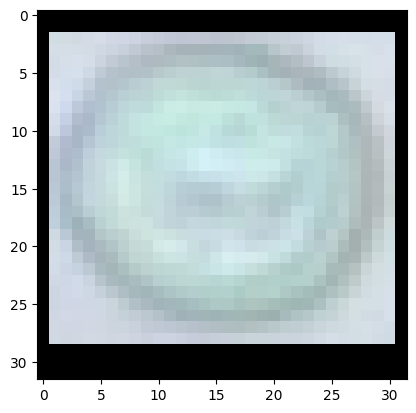

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
input_image = np.expand_dims(pad_img(x_train[0], (32,32)), axis=0)

In [ ]:
model.predict(input_image)

1/1 [==============================] - 0s 447ms/step


array([[0.00104464, 0.99895537]], dtype=float32)

In [6]:
labels = {
    0 : "Normal",
    1 : "Abnormal"
}

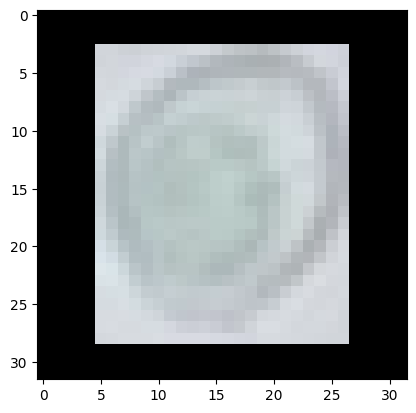

1/1 [==============================] - 0s 92ms/step
Abnormal


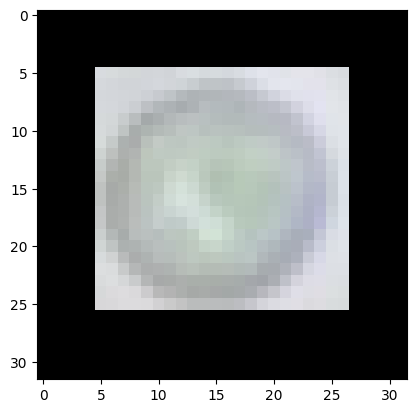

1/1 [==============================] - 0s 46ms/step
Normal


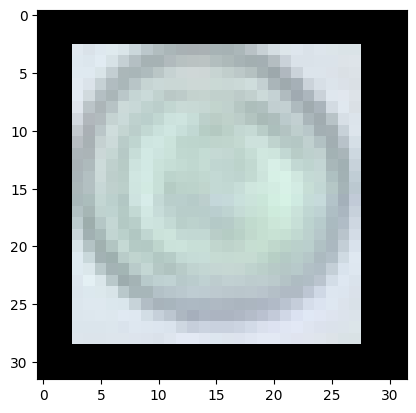

1/1 [==============================] - 0s 34ms/step
Abnormal


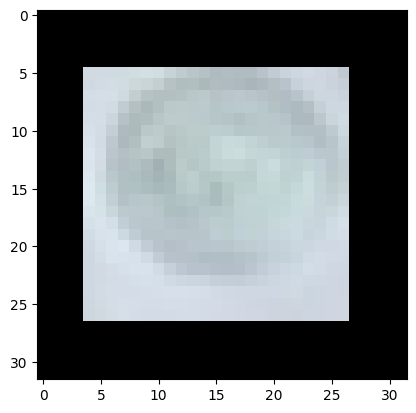

1/1 [==============================] - 0s 23ms/step
Normal


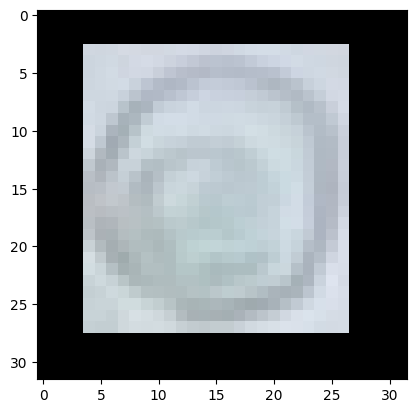

1/1 [==============================] - 0s 31ms/step
Abnormal


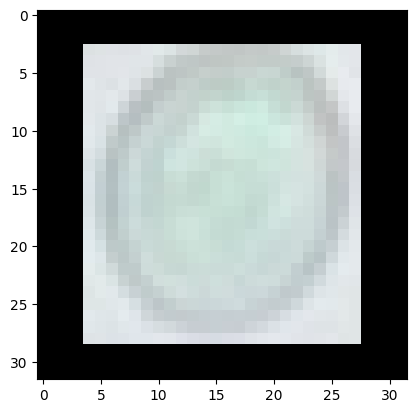

1/1 [==============================] - 0s 22ms/step
Normal


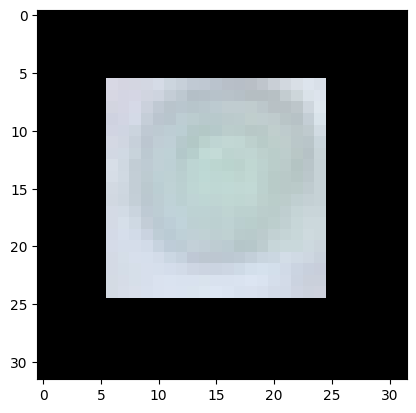

1/1 [==============================] - 0s 22ms/step
Normal


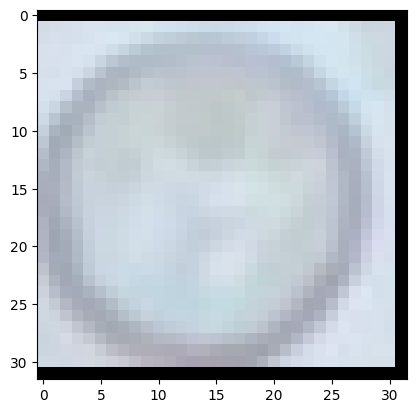

1/1 [==============================] - 0s 26ms/step
Normal


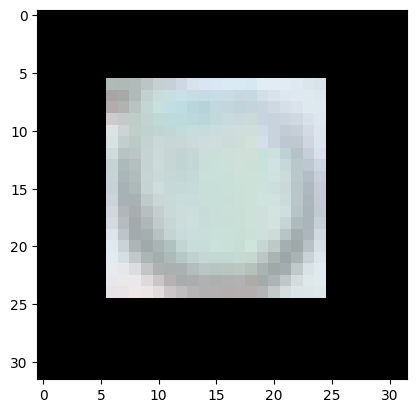

1/1 [==============================] - 0s 26ms/step
Normal


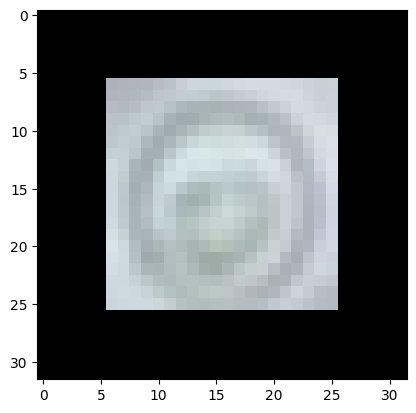

1/1 [==============================] - 0s 25ms/step
Abnormal


In [ ]:
for i in range(10):
  img = pad_img(x_train[i], (32,32))
  plt.imshow(img)
  plt.show()
  input_image = np.expand_dims(pad_img(x_train[i], (32,32)), axis=0)
  print(labels[np.argmax(model.predict(input_image))])

In [28]:
model = load_model('files/non-aug/best_yeast_classification_model.hdf5')

In [39]:
def predict_cell(train_folder,mask_folder,image_path, mask_path, save_folder):
  # for origin_image in os.listdir(origin_image_folder):
    #print(dem1)
    anh_goc = cv2.imread(os.path.join(train_folder,image_path))
    watershed = cv2.imread(os.path.join(mask_folder, mask_path))

    anh_xam = cv2.cvtColor(watershed, cv2.COLOR_BGR2GRAY)
    ret,nguong1 = cv2.threshold(anh_xam, 127, 255, cv2.THRESH_BINARY)
    nguong2 = cv2.bitwise_not(nguong1)
    contours, _ = cv2.findContours(nguong2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    MIN_HEIGHT = 4
    MAX_HEIGHT = anh_goc.shape[0] *0.5

    for cnt in contours[:-1]:
      x,y,w,h = cv2.boundingRect(cnt)
      if w > MIN_HEIGHT and w <MAX_HEIGHT:
        crop_number = anh_goc[y-1:y+h+1, x-1:x+w+1]
        crop_number = pad_img(crop_number, (32, 32))
        label = model.predict(np.expand_dims(crop_number, axis=0))
        if(np.argmax(label)) :
          cv2.rectangle(anh_goc, (x, y), (x + w, y + h), (255, 0, 255), 2)
        else:
          cv2.rectangle(anh_goc, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # saved_path = cropped_cells_folder+ '/{}_{}.png'.format(dem1, dem)
        # cv2_imshow(crop_number)
        #cv2.imwrite(saved_path, crop_number)
    cv2_imshow(anh_goc)
    cv2.imwrite(os.path.join(save_folder, "predicted_cell" + image_path), anh_goc)
# print(len(train_anh_goc_list))
# print(len(train_watershed_mask_list))

###*Test thử trên ảnh đã gán nhãn*

In [40]:
test_image_folder = "BackTest/2h"
test_mask_folder = "BackTest/2h_watershed"
test_image_list = sorted(os.listdir(test_image_folder))
test_mask_list = sorted(os.listdir(test_mask_folder))
save_folder = "Predict_Image"
for i in range(len(test_image_list)):
  predict_cell(test_image_folder,test_mask_folder,test_image_list[i], test_mask_list[i],save_folder)


Output hidden; open in https://colab.research.google.com to view.